**Practical 9**
Yash Rahate



# Apache Spark

In [ ]:
!apt-get install openjdk-11-jdk -y
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

import findspark
findspark.init()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.26+4-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
tar: spark-3.5.0-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Batch and Stream Analysis") \
    .getOrCreate()


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your CSV file here

import pandas as pd

# Read into Pandas to inspect and convert to Spark
df_pandas = pd.read_csv("/content/manufacturing_6G_dataset.csv")  # Rename to your file name
df_pandas['Timestamp'] = pd.to_datetime(df_pandas['Timestamp'])

from pyspark.sql.types import *

# Create Spark DataFrame
df_spark = spark.createDataFrame(df_pandas)
df_spark.printSchema()
df_spark.show(5)


Saving manufacturing_6G_dataset.csv to manufacturing_6G_dataset (3).csv
root
 |-- Timestamp: timestamp (nullable = true)
 |-- Machine_ID: long (nullable = true)
 |-- Operation_Mode: string (nullable = true)
 |-- Temperature_C: double (nullable = true)
 |-- Vibration_Hz: double (nullable = true)
 |-- Power_Consumption_kW: double (nullable = true)
 |-- Network_Latency_ms: double (nullable = true)
 |-- Packet_Loss_%: double (nullable = true)
 |-- Quality_Control_Defect_Rate_%: double (nullable = true)
 |-- Production_Speed_units_per_hr: double (nullable = true)
 |-- Predictive_Maintenance_Score: double (nullable = true)
 |-- Error_Rate_%: double (nullable = true)
 |-- Efficiency_Status: string (nullable = true)

+-------------------+----------+--------------+-----------------+------------------+--------------------+------------------+------------------+-----------------------------+-----------------------------+----------------------------+------------------+-----------------+
|          

# Batch Data Analysis

In [ ]:
# Convert to Pandas for plotting
df = df_spark.toPandas()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

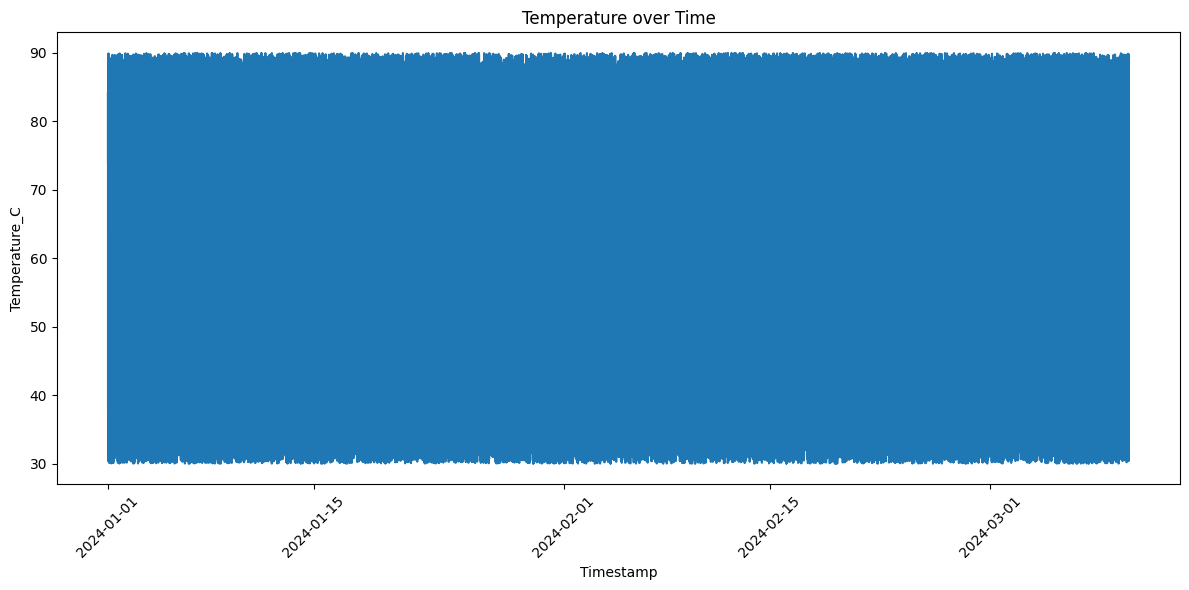

In [ ]:
# Temperature over time
plt.figure(figsize=(12,6))
sns.lineplot(x='Timestamp', y='Temperature_C', data=df)
plt.title('Temperature over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

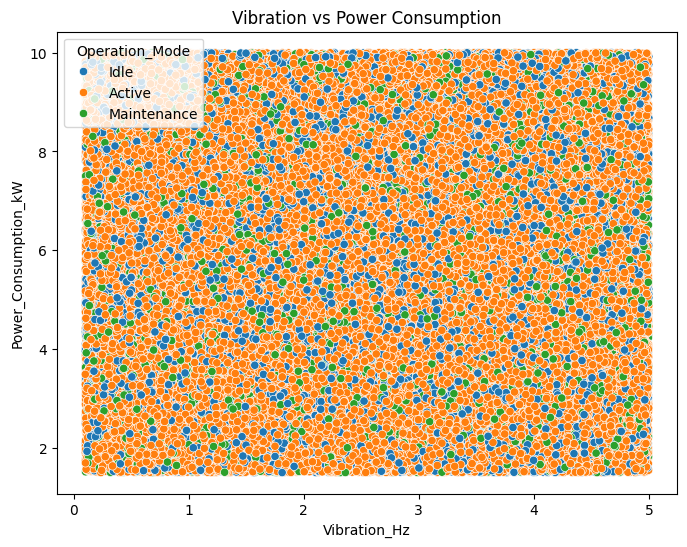

In [ ]:
# Vibration vs Power Consumption
plt.figure(figsize=(8,6))
sns.scatterplot(x='Vibration_Hz', y='Power_Consumption_kW', hue='Operation_Mode', data=df)
plt.title('Vibration vs Power Consumption')
plt.show()

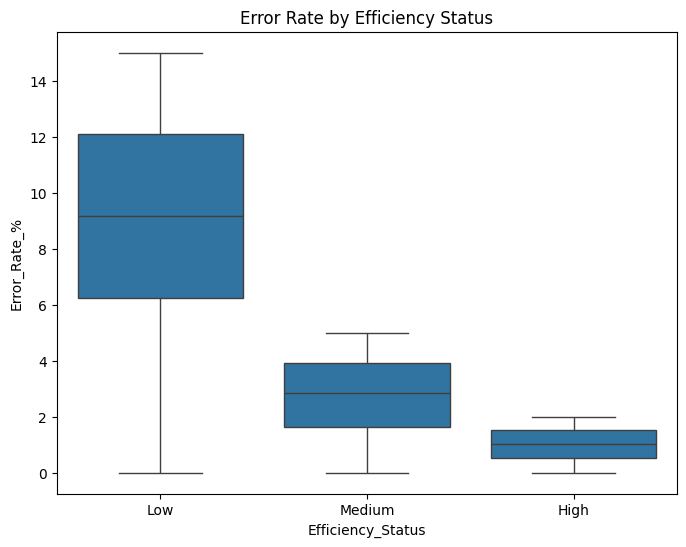

In [ ]:
# Error Rate distribution by Efficiency Status
plt.figure(figsize=(8,6))
sns.boxplot(x='Efficiency_Status', y='Error_Rate_%', data=df)
plt.title('Error Rate by Efficiency Status')
plt.show()

# Streamed data Analysis

In [ ]:
import os
import time

In [ ]:
stream_dir = "/content/stream_data"
os.makedirs(stream_dir, exist_ok=True)


In [ ]:
import pandas as pd

# Load full dataset using pandas
pdf = pd.read_csv("/content/manufacturing_6G_dataset.csv")

# Split into chunks (simulate streaming data)
chunk_size = 10  # you can change this
for i in range(0, len(pdf), chunk_size):
    chunk = pdf.iloc[i:i+chunk_size]
    chunk.to_csv(f"{stream_dir}/chunk_{i}.csv", index=False)


In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

schema = df_spark.schema


# Read the stream
streaming_df = spark.readStream \
    .option("maxFilesPerTrigger", 1) \
    .schema(schema) \
    .csv(stream_dir)

# Aggregate temperature per operation mode
agg_df = streaming_df.groupBy("Operation_Mode").agg(avg("Temperature_C").alias("Avg_Temperature"))

# Display in-memory table instead of just console
query = agg_df.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("temperature_summary") \
    .start()



In [ ]:
import time
time.sleep(20)  # let the stream run

# Query the results after streaming has processed some data
spark.sql("SELECT * FROM temperature_summary").show()


+--------------+------------------+
|Operation_Mode|   Avg_Temperature|
+--------------+------------------+
|   Maintenance|51.738948850267455|
|Operation_Mode|              NULL|
|        Active| 59.23779526897999|
|          Idle| 60.66350160154896|
+--------------+------------------+



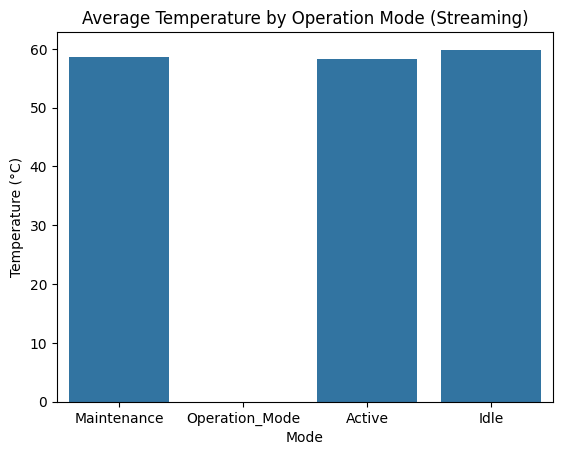

In [ ]:
temp_df = spark.sql("SELECT * FROM temperature_summary").toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Operation_Mode', y='Avg_Temperature', data=temp_df)
plt.title("Average Temperature by Operation Mode (Streaming)")
plt.ylabel("Temperature (°C)")
plt.xlabel("Mode")
plt.show()


In [ ]:
spark.stop()
